<a href="https://colab.research.google.com/github/Procuste34/lenia/blob/main/Custom_Lenia_avec_EvoJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from collections import namedtuple
from functools import partial

import matplotlib.pyplot as plt

In [2]:
Carry = namedtuple('Carry', ['world', 'params', 'asset', 'temp'])
Params = namedtuple('Params', ['m', 's', 'h'])
Accum = namedtuple('Accum', ['world', 'stats'])
Asset = namedtuple('Asset', ['fK', 'X', 'reshape_c_k', 'reshape_k_c', 'R', 'dt'])
Temp = namedtuple('Temp', ['last_center', 'last_shift', 'total_shift', 'last_angle'])
Stats = namedtuple('Stats', ['mass'])
Others = namedtuple('Others', ['D', 'K', 'cells', 'init_cells'])

In [3]:
n_step = 200

world_size = 128
world_scale = 2

n_kernels = 15
n_channels = 3
n_cells_size = 30

n_cells = n_cells_size * n_cells_size * n_channels

# Choix d'un pattern : 5N7KKM

In [28]:
patterns = {}
patterns["5N7KKM"] = {"name":"Aquarium (swarm)","R":12,"T":2,"kernels":[
  {"b":[1],"m":0.22,"s":0.0628,"h":0.174,"r":0.87,"c0":0,"c1":0},
  {"b":[1],"m":0.351,"s":0.1539,"h":0.46,"r":0.52,"c0":0,"c1":0},
  {"b":[1,1/4],"m":0.177,"s":0.0333,"h":0.31,"r":0.58,"c0":0,"c1":0},
  {"b":[0,1],"m":0.126,"s":0.0525,"h":0.242,"r":0.89,"c0":1,"c1":1},
  {"b":[1],"m":0.437,"s":0.0797,"h":0.508,"r":0.78,"c0":1,"c1":1},
  {"b":[3/4,1],"m":0.234,"s":0.0369,"h":0.566,"r":0.79,"c0":1,"c1":1},
  {"b":[1],"m":0.179,"s":0.0653,"h":0.406,"r":1.0,"c0":2,"c1":2},
  {"b":[1],"m":0.489,"s":0.1213,"h":0.27,"r":0.64,"c0":2,"c1":2},
  {"b":[1],"m":0.419,"s":0.1775,"h":0.588,"r":0.96,"c0":2,"c1":2},
  {"b":[11/12,1],"m":0.341,"s":0.1388,"h":0.294,"r":0.66,"c0":0,"c1":1},
  {"b":[3/4,1],"m":0.469,"s":0.1054,"h":0.388,"r":0.69,"c0":0,"c1":2},
  {"b":[1,11/12],"m":0.369,"s":0.0721,"h":0.62,"r":0.61,"c0":1,"c1":0},
  {"b":[1],"m":0.219,"s":0.0898,"h":0.348,"r":0.81,"c0":1,"c1":2},
  {"b":[1/6,1],"m":0.385,"s":0.1102,"h":0.436,"r":0.81,"c0":2,"c1":0},
  {"b":[1],"m":0.208,"s":0.0749,"h":0.39,"r":0.71,"c0":2,"c1":1}],
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.12,0,0,0,0,0,0,0], [0,0,0,0,0.49,0,0,0,0,0,0,0.23,0.47,0.31,0.93,0.75,0,0,0,0], [0,0,0,0.23,0,0,0.65,0.68,0.12,0,0,0,0.02,0.40,0.82,0.86,0,0.19,0,0], [0,0,0.01,0.01,0.77,1.00,0.98,1.00,0.97,0.85,0.70,0.55,0.12,0.15,0.01,0,0,0.95,0,0], [0,0,0,0.66,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.74,0.76,0.27,0,0,0.18,0.59,0.31,0], [0,0.04,0.08,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.68,0.07,0,0,0,0,0,0], [0,0,0.29,1.00,1.00,1.00,1.00,0.90,1.00,0.92,0.58,0.84,0.89,0.39,0,0,0.04,1.00,0,0], [0,0.06,0.27,1.00,1.00,1.00,0.82,0.39,0,0,0,0.12,0.87,0.70,0.58,0.04,0.40,1.00,0.35,0], [0,0.21,0.38,1.00,1.00,0.66,0,0,0,0,0,0,1.00,0.79,0.74,0.16,0.31,0.42,0,0], [0,0.26,0.50,1.00,1.00,0.46,0,0,0,0,0,0.40,1.00,1.00,0.71,0.16,0,0.22,0,0], [0,0.14,0.48,1.00,1.00,0.77,0,0,0,0,0,1.00,1.00,1.00,0.79,0,0,0,0,0], [0,0,0.16,1.00,1.00,1.00,0.19,0,0,0.09,0.20,0.57,1.00,1.00,0.74,0,0,0,0,0], [0,0,0,0.59,1.00,1.00,0.85,0.75,1.00,1.00,1.00,1.00,1.00,1.00,0.47,0,0,0,0,0], [0,0,0,0,0.95,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0.44,0,0,0,0,0], [0,0,0,0,0.25,0.79,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0,0,0,0,0,0], [0,0,0,0,0.04,0.06,0.26,0.61,1.00,1.00,1.00,1.00,1.00,0,0,0.32,0,0,0,0], [0,0,0,0,0,0,0.15,0,0.02,0.23,0.24,0.05,0,0,0.25,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.02,0.04,0,0,0.08,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.03,0.43,0,0,0,0,0,0,0,0,0,0], [0,0,0.14,0.47,0,0,0.27,0.92,0.87,0.70,0,0,0,0,0,0,0,0,0,0], [0,0,0.86,1.00,0.66,1.00,1.00,1.00,1.00,0.33,0,0,0,0,0,0,0,0,0,0], [0,0,1.00,1.00,1.00,1.00,1.00,0.13,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,1.00,1.00,1.00,1.00,1.00,0,0.22,0.30,0,0,0,0,0,0,0,0,0,0], [0,0,0.76,1.00,1.00,1.00,1.00,1.00,0.83,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.71,1.00,1.00,1.00,1.00,0.77,0.81,0.75,0,0,0,0,0,0,0,0,0,0], [0,0,0.69,1.00,1.00,1.00,0.88,0.24,0.35,0.62,0.35,0.09,0,0,0,0,0,0,0,0], [0,0,0.29,1.00,1.00,1.00,0.98,0.38,0.13,0.65,0.88,0.32,0,0,0,0,0,0,0,0], [0,0,0,0.09,1.00,1.00,1.00,0.93,0.77,0.88,0.24,0.03,0.69,1.00,0.78,0,0,0,0,0], [0,0,0,0,0.44,1.00,1.00,1.00,1.00,1.00,0.76,0.83,1.00,0.92,0.17,0,0,0,0,0], [0,0,0,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0,0,0,0,0,0,0], [0,0,0,0,0,0.36,1.00,1.00,1.00,1.00,1.00,1.00,0.12,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.39,0.79,1.00,1.00,1.00,0.48,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.16,0.59,1.00,1.00,1.00,0.13,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.04,0.16,0.02,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0.51,0.46,0.26,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.38,1.00,1.00,0.96,0.85,0.57,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.63,1.00,1.00,1.00,1.00,0.96,0.70,0.08,0,0,0,0,0,0], [0,0,0,0,0.01,0.36,1.00,1.00,1.00,1.00,1.00,1.00,0.82,0.49,0,0,0,0,0,0], [0,0,0,0,0.05,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.65,0.04,0,0,0,0], [0,0,0.01,0,0.08,0.52,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.93,0,0,0,0,0], [0,0,0.03,0,0.09,0.49,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.58,0.04,0,0,0,0,0], [0,0,0.02,0,0.08,0.50,1.00,1.00,1.00,1.00,1.00,0.81,0,0,0,0,0.08,0.01,0,0], [0,0,0,0,0.04,0.47,1.00,1.00,1.00,1.00,0.40,0,0,0,0,0.77,0.85,0.35,0,0], [0,0,0,0,0.03,0.41,1.00,1.00,1.00,1.00,0.20,0,0,0.01,1.00,1.00,1.00,0.55,0,0], [0,0,0,0,0,0.30,0.98,1.00,1.00,1.00,0.68,0.09,0.26,1.00,1.00,1.00,1.00,0.70,0.19,0], [0,0,0,0,0,0.13,0.55,0.95,1.00,1.00,1.00,0.89,1.00,1.00,1.00,1.00,1.00,0.85,0.67,0.24], [0,0,0,0,0,0.02,0.31,0.63,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.45], [0,0,0,0,0,0,0.12,0.44,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.91,0.36], [0,0,0,0,0,0,0,0.16,0.48,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.86,0.06], [0,0,0,0,0,0,0,0,0.13,0.32,0.70,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.28,0], [0,0,0,0,0,0,0,0,0,0.06,0.18,0.32,0.57,0.90,1.00,1.00,1.00,0.08,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.04,0.12,0.25,0.39,0.31,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0,0,0,0,0]]]
}
pattern = patterns["5N7KKM"]

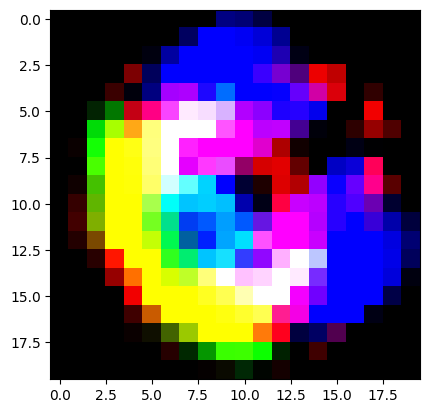

In [35]:
plt.imshow(jnp.transpose(jnp.asarray(pattern['cells']), axes=[1, 2, 0]))

# fonctions auxiliaires

In [ ]:
def create_world_from_cells(cells_flatten):
  #cells_flatten : vecteur des cellules du pattern, de taille (e*e*c,)

  cells = jnp.reshape(cells_flatten, (n_cells_size, n_cells_size, n_channels)) # (e, e, c)

  midX = world_size//2
  midY = world_size//2

  A = jnp.zeros((world_size, world_size, n_channels))





  return
